In [1466]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import os
from glicko2 import Player

from helpers import davidson_mov
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


In [1467]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1468]:
df_raw = pd.read_csv('EPL_RAW.csv')

In [1469]:
def process_attempted_and_total(column):
    """
    Processes a column in the format 'xx/yy (zz%)' to extract 'attempted' and 'total'.
    Args:
        column (str): The column name to process.
    """
    # Fill NaN with '0/0 (0%)' to ensure consistent processing
    df_raw[column] = df_raw[column].fillna('0/0 (0%)')
    
    # Extract 'attempted' and 'total' using a regular expression
    df_raw[[f'{column}Attempted', f'{column}Total']] = df_raw[column].str.extract(r'(\d+)/(\d+)').astype(int)

    # Drop the original column (optional)
    df_raw.drop(columns=[column], inplace=True)

# List of columns to process
columns_to_process = ['homeaccurateLongBalls', 'awayaccurateLongBalls', 'homeaccurateCross', 'awayaccurateCross']

# Apply the function to each column
for col in columns_to_process:
    process_attempted_and_total(col)


In [1470]:
df_raw.rename(columns={'homeaccurateCrossAttempted': 'homeaccurateCross'}, inplace=True)
df_raw.rename(columns={'homeaccurateCrossTotal': 'hometotalCross'}, inplace=True)
df_raw.rename(columns={'awayaccurateCrossAttempted': 'awayaccurateCross'}, inplace=True)
df_raw.rename(columns={'awayaccurateCrossTotal': 'awaytotalCross'}, inplace=True)


In [1471]:
# List of columns to rename
columns_to_rename = ['homegroundDuelsPercentage', 'awaygroundDuelsPercentage','homeaerialDuelsPercentage','awayaerialDuelsPercentage']
# Rename columns by removing "Percentage"
df_raw.rename(columns={col: col.replace('Percentage', '') for col in columns_to_rename}, inplace=True)
# Verify the changes
print(df_raw.columns)


Index(['eventId', 'homeId', 'homeTeam', 'awayId', 'awayTeam', 'homeScore',
       'awayScore', 'FTR', 'date', 'time',
       ...
       'awaypunches', 'datetime', 'homeaccurateLongBallsAttempted',
       'homeaccurateLongBallsTotal', 'awayaccurateLongBallsAttempted',
       'awayaccurateLongBallsTotal', 'homeaccurateCross', 'hometotalCross',
       'awayaccurateCross', 'awaytotalCross'],
      dtype='object', length=107)


In [1472]:
import pandas as pd

# Assuming your DataFrame is called df

# Function to split the data and extract relevant parts
def process_duels_column(column):
    # Remove everything in parentheses, then split by '/'
    df_raw[[f'{column}Won', f'{column}Total']] = df_raw[column].str.extract(r'(\d+)/(\d+)').astype(int)

# Process the home and away columns
process_duels_column('homegroundDuels')
process_duels_column('awaygroundDuels')
process_duels_column('homeaerialDuels')
process_duels_column('awayaerialDuels')

# Drop the original columns if no longer needed
df_raw.drop(columns=['homegroundDuels', 'awaygroundDuels','homeaerialDuels','awayaerialDuels'], inplace=True)

# Verify the changes


In [1473]:
df_raw['homewonTacklePercent'].fillna('0%',inplace=True)
df_raw['awaywonTacklePercent'].fillna('0%',inplace=True)

In [1474]:
df_raw['homeballPossession'] = df_raw['homeballPossession'].str.rstrip('%').astype(int)
df_raw['awayballPossession'] = df_raw['awayballPossession'].str.rstrip('%').astype(int)
df_raw['homewonTacklePercent'] = df_raw['homewonTacklePercent'].str.rstrip('%').astype(int)
df_raw['awaywonTacklePercent'] = df_raw['awaywonTacklePercent'].str.rstrip('%').astype(int)

In [1475]:
df_raw['homeShootingEfficiency'] = df_raw['homeshotsOnGoal'] / ( df_raw['homeshotsOffGoal'] + df_raw['homeshotsOnGoal'] )
df_raw['awayShootingEfficiency'] = df_raw['awayshotsOnGoal'] / ( df_raw['awayshotsOffGoal'] + df_raw['homeshotsOnGoal'])
# Replace infinities with 0
df_raw['homeShootingEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)
df_raw['awayShootingEfficiency'].replace([np.inf, -np.inf], 0, inplace=True)

df_raw['homeShootingEfficiency'].fillna(0,inplace=True)
df_raw['awayShootingEfficiency'].fillna(0,inplace=True)

In [1476]:
# Count the number of 0s in homebigChanceCreated
home_zeros = (df_raw['homebigChanceCreated'] == 0).sum()

# Count the number of 0s in awaybigChanceCreated
away_zeros = (df_raw['awaybigChanceCreated'] == 0).sum()

print(f"Number of 0s in homebigChanceCreated: {home_zeros}")
print(f"Number of 0s in awaybigChanceCreated: {away_zeros}")


Number of 0s in homebigChanceCreated: 949
Number of 0s in awaybigChanceCreated: 1150


In [1477]:
df_raw['homebigChanceScored'].fillna(df_raw['homeScore'], inplace=True)
df_raw['awaybigChanceScored'].fillna(df_raw['awayScore'], inplace=True)
df_raw['homebigChanceCreated'].fillna(df_raw['homeScore'], inplace=True)
df_raw['awaybigChanceCreated'].fillna(df_raw['awayScore'], inplace=True)

# Update homebigChanceCreated to be at least homebigChanceScored
df_raw['homebigChanceCreated'] = df_raw.apply(
    lambda row: max(row['homebigChanceCreated'], row['homebigChanceScored']), axis=1
)

df_raw['awaybigChanceCreated'] = df_raw.apply(
    lambda row: max(row['awaybigChanceCreated'], row['awaybigChanceScored']), axis=1
)

# Ensure homebigChanceCreated and homebigChanceScored are at least equal to homeScore
df_raw['homebigChanceCreated'] = df_raw.apply(
    lambda row: max(row['homebigChanceCreated'], row['homeScore']), axis=1
)
df_raw['homebigChanceScored'] = df_raw.apply(
    lambda row: max(row['homebigChanceScored'], row['homeScore']), axis=1
)

df_raw['awaybigChanceCreated'] = df_raw.apply(
    lambda row: max(row['awaybigChanceCreated'], row['awayScore']), axis=1
)
df_raw['awaybigChanceScored'] = df_raw.apply(
    lambda row: max(row['awaybigChanceScored'], row['awayScore']), axis=1
)

# If homebigChanceCreated is not 0, add its value to homeScore and update homebigChanceCreated
df_raw['homebigChanceCreated'] = df_raw.apply(
    lambda row: row['homebigChanceCreated'] + row['homeScore'] if row['homebigChanceCreated'] != 0 else row['homebigChanceCreated'],
    axis=1
)

df_raw['awaybigChanceCreated'] = df_raw.apply(
    lambda row: row['awaybigChanceCreated'] + row['awayScore'] if row['awaybigChanceCreated'] != 0 else row['awaybigChanceCreated'],
    axis=1
)


In [1478]:
df_raw['homebigChanceConversionRate'] = df_raw.apply(
    lambda row: 0 if row['homebigChanceCreated'] == 0 
    else row['homebigChanceScored'] / row['homebigChanceCreated'],
    axis=1
)

df_raw['awaybigChanceConversionRate'] = df_raw.apply(
    lambda row: 0 if row['awaybigChanceCreated'] == 0 
    else row['awaybigChanceScored'] / row['awaybigChanceCreated'],
    axis=1
)


In [1479]:
df_raw['homebigChanceConversionRate'].isnull().sum()

0

In [1480]:
df_raw['awaygoalkeeperSaves'].fillna(0, inplace=True)
df_raw['homegoalkeeperSaves'].fillna(0,inplace=True)

In [1481]:
df_raw['homeSavePercentage'] = df_raw['homegoalkeeperSaves'] / (df_raw['awayshotsOnGoal'])
df_raw['awaySavePercentage'] = df_raw['awaygoalkeeperSaves'] / (df_raw['homeshotsOnGoal'])

In [1482]:
# Replace infinities with 1
df_raw['homeSavePercentage'].replace([float('inf'), float('-inf')], 1, inplace=True)
df_raw['awaySavePercentage'].replace([float('inf'), float('-inf')], 1, inplace=True)

# Optionally, handle NaN values if they exist
df_raw['homeSavePercentage'].fillna(0, inplace=True)
df_raw['awaySavePercentage'].fillna(0, inplace=True)


In [1483]:
df_raw['homepassAccuracy'] = df_raw['homeaccuratePasses'] / df_raw['homepasses']
df_raw['awaypassAccuracy'] = df_raw['awayaccuratePasses'] / df_raw['awaypasses']
df_raw['homeCrossAccuracy'] = df_raw['homeaccurateCross']/df_raw['hometotalCross']
df_raw['awayCrossAccuracy'] = df_raw['awayaccurateCross']/df_raw['awaytotalCross']

df_raw['homeCrossAccuracy'].fillna(0, inplace=True)
df_raw['homeCrossAccuracy'].isnull().sum()

df_raw['awayCrossAccuracy'].fillna(0, inplace=True)
df_raw['awayCrossAccuracy'].isnull().sum()

df_raw['homePassPower'] = df_raw['homepassAccuracy'] + df_raw['homeCrossAccuracy']
df_raw['awayPassPower'] = df_raw['awaypassAccuracy'] + df_raw['awayCrossAccuracy']

In [1484]:
df_raw['homeBoxPresence'] = df_raw['hometotalShotsInsideBox']/ (df_raw['hometotalShotsInsideBox'] + df_raw['hometotalShotsOutsideBox'])
df_raw['awayBoxPresence'] = df_raw['awaytotalShotsInsideBox']/ (df_raw['awaytotalShotsInsideBox'] + df_raw['awaytotalShotsOutsideBox'])

In [1485]:
df_raw['homeBoxPresence'].fillna(0, inplace=True)
df_raw['awayBoxPresence'].fillna(0, inplace=True)

df_raw['homeBoxPresence'].isnull().sum()
df_raw['awayBoxPresence'].isnull().sum()

0

In [1486]:
df_raw['homegroundDuelPercent'] = (df_raw['homegroundDuelsWon']/df_raw['homegroundDuelsTotal'])
df_raw['homeaerialDuelPercent'] = (df_raw['homeaerialDuelsWon']/df_raw['homeaerialDuelsTotal'])
df_raw['awaygroundDuelPercent'] = (df_raw['awaygroundDuelsWon']/df_raw['awaygroundDuelsTotal'])
df_raw['awayaerialDuelPercent'] = (df_raw['homeaerialDuelsWon']/df_raw['awayaerialDuelsTotal'])


df_raw['homeDuelPower'] = (df_raw['homegroundDuelPercent'] + df_raw['homeaerialDuelPercent'])
df_raw['awayDuelPower'] = (df_raw['awaygroundDuelPercent'] + df_raw['awayaerialDuelPercent'])

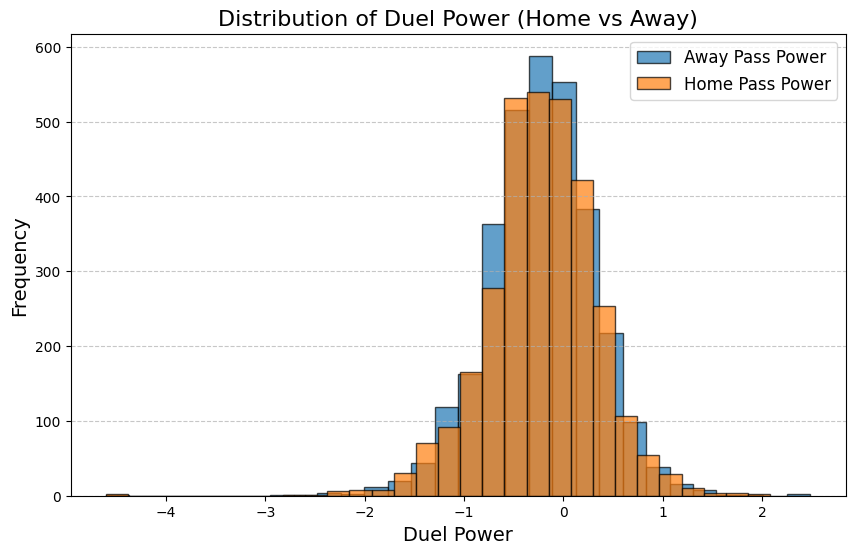

In [1743]:
# Assuming df_raw is loaded with 'awayDuelPower' and 'homeDuelPower' columns
plt.figure(figsize=(10, 6))

# Plot histograms for both awayDuelPower and homeDuelPower
plt.hist(
    df_raw['log_awayDiscipline'].dropna(),
    bins=30,
    alpha=0.7,
    label='Away Pass Power',
    edgecolor='k',
)
plt.hist(
    df_raw['log_homeDiscipline'].dropna(),
    bins=30,
    alpha=0.7,
    label='Home Pass Power',
    edgecolor='k',
)

# Add titles and labels
plt.title('Distribution of Duel Power (Home vs Away)', fontsize=16)
plt.xlabel('Duel Power', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [1488]:
df_raw['homePossessionEfficiency'] = df_raw['homeballPossession']/100 * df_raw['homepassAccuracy']
df_raw['awayPossessionEfficiency'] = df_raw['awayballPossession']/100 * df_raw['awaypassAccuracy']

In [1489]:
df_raw['awayfinalThirdEntries'].fillna(df_raw['awayfinalThirdEntries'].median(),inplace=True)
df_raw['homefinalThirdEntries'].fillna(df_raw['homefinalThirdEntries'].median(),inplace=True)

df_raw['homefinalThirdEfficiency'] = df_raw['homefinalThirdEntries'] / df_raw['homepasses']
df_raw['awayfinalThirdEfficiency'] = df_raw['awayfinalThirdEntries'] / df_raw['awaypasses']

In [ ]:
df_raw['homeFoulThreatIndex'] = df_raw['awayfouls'] / df_raw['homefinalThirdEntries']  
df_raw['awayFoulThreatIndex'] = df_raw['homefouls'] / df_raw['awayfinalThirdEntries'] 

In [1491]:
epsilon = 1

df_raw['homeShootingEfficiency'] = df_raw['homeShootingEfficiency'].replace(0, epsilon)
df_raw['homebigChanceConversionRate'] = df_raw['homebigChanceConversionRate'].replace(0, epsilon)
df_raw['homeshotsOnGoal'] = df_raw['homeshotsOnGoal'].replace(0, epsilon)

df_raw['awayShootingEfficiency'] = df_raw['awayShootingEfficiency'].replace(0, epsilon)
df_raw['awaybigChanceConversionRate'] = df_raw['awaybigChanceConversionRate'].replace(0, epsilon)
df_raw['awayshotsOnGoal'] = df_raw['awayshotsOnGoal'].replace(0, epsilon)


In [1492]:
import numpy as np

df_raw['log_homeShootingEfficiency'] = np.log(df_raw['homeShootingEfficiency'])
df_raw['log_homebigChanceConversionRate'] = np.log(df_raw['homebigChanceConversionRate'])
df_raw['log_homeshotsOnGoal'] = np.log(df_raw['homeshotsOnGoal'])

df_raw['log_awayShootingEfficiency'] = np.log(df_raw['awayShootingEfficiency'])
df_raw['log_awaybigChanceConversionRate'] = np.log(df_raw['awaybigChanceConversionRate'])
df_raw['log_awayshotsOnGoal'] = np.log(df_raw['awayshotsOnGoal'])


In [1493]:
df_raw['homeXGc'] = (
    df_raw['log_homeShootingEfficiency'] +
    df_raw['log_homebigChanceConversionRate'] +
    df_raw['log_homeshotsOnGoal']
)

df_raw['awayXGc'] = (
    df_raw['log_awayShootingEfficiency'] +
    df_raw['log_awaybigChanceConversionRate'] +
    df_raw['log_awayshotsOnGoal']
)


In [1495]:
df_raw['homeATI'] = (df_raw['homebigChanceCreated'] + df_raw['hometotalShotsInsideBox']) * df_raw['homepassAccuracy']
df_raw['awayATI'] = (df_raw['awaybigChanceCreated'] + df_raw['awaytotalShotsInsideBox']) * df_raw['awaypassAccuracy']

In [ ]:
median_value = df_raw['hometotalTackle'].median()
df_raw['hometotalTackle'].fillna(median_value,inplace=True)

median_value = df_raw['hometotalClearance'].median()
df_raw['hometotalClearance'].fillna(median_value,inplace=True)

median_value = df_raw['homeinterceptionWon'].median()
df_raw['homeinterceptionWon'].fillna(median_value,inplace=True)

# Fill nulls in away columns with their respective medians
median_value = df_raw['awaytotalTackle'].median()
df_raw['awaytotalTackle'].fillna(median_value, inplace=True)

median_value = df_raw['awaytotalClearance'].median()
df_raw['awaytotalClearance'].fillna(median_value, inplace=True)

median_value = df_raw['awayinterceptionWon'].median()
df_raw['awayinterceptionWon'].fillna(median_value, inplace=True)



Null values after filling:
awaytotalTackle: 0
awaytotalClearance: 0
awayinterceptionWon: 0


In [1640]:
df_raw['homeTerritorialDominance'] = df_raw['homePossessionEfficiency'] * df_raw['homefinalThirdEfficiency']
df_raw['awayTerritorialDominance'] = df_raw['awayPossessionEfficiency'] * df_raw['awayfinalThirdEfficiency']

In [1641]:
df_raw['homePassingDisruption'] = (df_raw['hometotalTackle'] + df_raw['homeinterceptionWon']) / df_raw['awaypasses']
df_raw['awayPassingDisruption'] = (df_raw['awaytotalTackle'] + df_raw['awayinterceptionWon']) / df_raw['homepasses']

In [1642]:
df_raw['homeTransitionEfficiency'] = df_raw['hometotalShotsInsideBox'] / df_raw['homefinalThirdEntries']
df_raw['awayTransitionEfficiency'] = df_raw['awaytotalShotsInsideBox'] / df_raw['awayfinalThirdEntries']

In [1645]:
df_raw['awaydispossessed'].mean()

4.969768223043332

In [1648]:
df_raw['homewonTackle'] = df_raw['homewonTacklePercent']/100 * df_raw['hometotalTackle']
df_raw['awaywonTackle'] = df_raw['awaywonTacklePercent']/100 * df_raw['awaytotalTackle']
df_raw['homewonTackle'] = df_raw['homewonTackle'].round()
df_raw['awaywonTackle'] = df_raw['awaywonTackle'].round()

In [1649]:
df_raw['hometotalShotsOnGoal'].median()

7.0

In [1707]:
import numpy as np

# Home Pressure Index
df_raw['homePressureIndex'] = np.where(
    df_raw['awaytotalShotsOnGoal'] == 0,
    ((df_raw['homeblockedScoringAttempt'] + df_raw['homeinterceptionWon'] + df_raw['hometotalClearance']) / 1) * 1.2,
    (df_raw['homeblockedScoringAttempt'] + df_raw['homeinterceptionWon'] + df_raw['hometotalClearance']) / df_raw['awaytotalShotsOnGoal']
)

# Away Pressure Index
df_raw['awayPressureIndex'] = np.where(
    df_raw['hometotalShotsOnGoal'] == 0,
    ((df_raw['awayblockedScoringAttempt'] + df_raw['awayinterceptionWon'] + df_raw['awaytotalClearance']) / 1) * 1.2,
    (df_raw['awayblockedScoringAttempt'] + df_raw['awayinterceptionWon'] + df_raw['awaytotalClearance']) / df_raw['hometotalShotsOnGoal']
)

# Apply natural log to the pressure indexes
df_raw['homePressureIndex'] = np.log(df_raw['homePressureIndex'] + epsilon)
df_raw['awayPressureIndex'] = np.log(df_raw['awayPressureIndex'] + epsilon)


In [1708]:
# Count the number of 0s in homebigChanceCreated
home_zeros = (df_raw['homebigChanceCreated'] == 0).sum()

print(f"Number of 0s in homebigChanceCreated: {home_zeros}")


Number of 0s in homebigChanceCreated: 438


In [1709]:
import numpy as np

# Home xDS
df_raw['homexDS'] = np.where(
    df_raw['awaybigChanceCreated'] == 0,
    (df_raw['homePressureIndex'] / 1) * 1.5,
    df_raw['homePressureIndex'] / df_raw['awaybigChanceCreated']
)

# Away xDS
df_raw['awayxDS'] = np.where(
    df_raw['homebigChanceCreated'] == 0,
    (df_raw['awayPressureIndex'] / 1) * 1.5,
    df_raw['awayPressureIndex'] / df_raw['homebigChanceCreated']
)


In [1716]:
df_raw['awayxDS'].mean()

0.7577512637531523

In [1717]:
df_raw['awayXGc'].mean()

-0.475650590873872

In [1723]:
df_raw['homefouls'].isnull().sum()

0

In [1736]:
df_raw['homeDiscipline'] = 1/(df_raw['homefouls']/df_raw['hometotalTackle'])
df_raw['awayDiscipline'] = 1/(df_raw['awayfouls']/df_raw['awaytotalTackle'])

In [1737]:

# Replace infinite values in homeDiscipline with 0
df_raw['homeDiscipline'].replace([np.inf, -np.inf], 0, inplace=True)
# Replace infinite values in homeDiscipline with 0
df_raw['awayDiscipline'].replace([np.inf, -np.inf], 0, inplace=True)



In [ ]:
import numpy as np

# Define a small constant to handle 0 or undefined values
epsilon = 1e-2

# Take the natural log of homeDiscipline and awayDiscipline
df_raw['homeDiscipline'] = np.log(df_raw['homeDiscipline'] + epsilon)
df_raw['awayDiscipline'] = np.log(df_raw['awayDiscipline'] + epsilon)



   homeDiscipline  log_homeDiscipline  awayDiscipline  log_awayDiscipline
0        1.250000            0.231112        0.294118           -1.190341
1        1.333333            0.295154        0.533333           -0.610032
2        0.700000           -0.342490        0.571429           -0.542267
3        0.388889           -0.919072        0.714286           -0.322569
4        0.875000           -0.122168        1.083333            0.089231


KeyError: 'log'